In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
%matplotlib inline

# Return Forecasting: Read Historical Daily Yen Futures Data
In this notebook, you will load historical Dollar-Yen exchange rate futures data and apply time series analysis and modeling to determine whether there is any predictable behavior.

In [2]:
# Futures contract on the Yen-dollar exchange rate:
# This is the continuous chain of the futures contracts that are 1 month to expiration
yen_futures = pd.read_csv(
    Path("yen.csv"), index_col="Date", infer_datetime_format=True, parse_dates=True
)
yen_futures.head()

,Open,High,Low,Last,Change,Settle,Volume,Previous Day Open Interest
Date,,,,,,,,
1976-08-02,3398.0,3401.0,3398.0,3401.0,NaN,3401.0,2.0,1.0
1976-08-03,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0.0,1.0
1976-08-04,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0.0,1.0
1976-08-05,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0.0,1.0
1976-08-06,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0.0,1.0


In [3]:
# Trim the dataset to begin on January 1st, 1990
yen_futures = yen_futures.loc["1990-01-01":, :]
yen_futures.head()

,Open,High,Low,Last,Change,Settle,Volume,Previous Day Open Interest
Date,,,,,,,,
1990-01-02,6954.0,6954.0,6835.0,6847.0,NaN,6847.0,48336.0,51473.0
1990-01-03,6877.0,6910.0,6865.0,6887.0,NaN,6887.0,38206.0,53860.0
1990-01-04,6937.0,7030.0,6924.0,7008.0,NaN,7008.0,49649.0,55699.0
1990-01-05,6952.0,6985.0,6942.0,6950.0,NaN,6950.0,29944.0,53111.0
1990-01-08,6936.0,6972.0,6936.0,6959.0,NaN,6959.0,19763.0,52072.0


In [10]:
yen_futures.tail()

,Open,High,Low,Last,Change,Settle,Volume,Previous Day Open Interest
Date,,,,,,,,
2019-10-09,9381.0,9391.5,9330.5,9343.5,38.5,9338.0,99153.0,145470.0
2019-10-10,9343.5,9380.5,9293.5,9301.0,34.5,9303.5,159397.0,144474.0
2019-10-11,9308.5,9309.0,9240.0,9267.0,52.5,9251.0,158810.0,147471.0
2019-10-14,9259.0,9292.0,9250.5,9261.0,14.0,9265.0,69457.0,153902.0
2019-10-15,9264.5,9280.0,9216.5,9220.0,43.5,9221.5,108342.0,151564.0


 # Return Forecasting: Initial Time-Series Plotting

 Start by plotting the "Settle" price. Do you see any patterns, long-term and/or short?

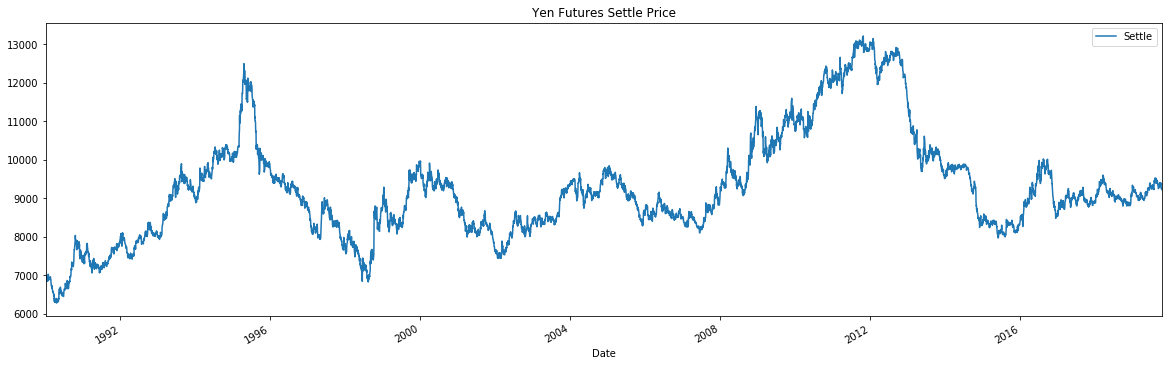

In [21]:
# Plot just the "Settle" column from the dataframe:
settle_plt = yen_futures['Settle'].plot(title= 'Yen Futures Settle Price', figsize=(20,6), legend=True)
settle_plt

*Answer*
 * Based on the plot above, we can see a long-term strengthening of the Japanese Yen against the Dollar. There do seem to be some more medium, 1-3 year consistent trends, but on a daily basis, there are a lot of short-term ups and downs.

---

# Decomposition Using a Hodrick-Prescott Filter

 Using a Hodrick-Prescott Filter, decompose the Settle price into a trend and noise.

In [ ]:
import statsmodels.api as sm

# Apply the Hodrick-Prescott Filter by decomposing the "Settle" price into two separate series:
yen_ts_noise, yen_ts_trend = sm.tsa.filters.hpfilter(yen_futures['Settle'])

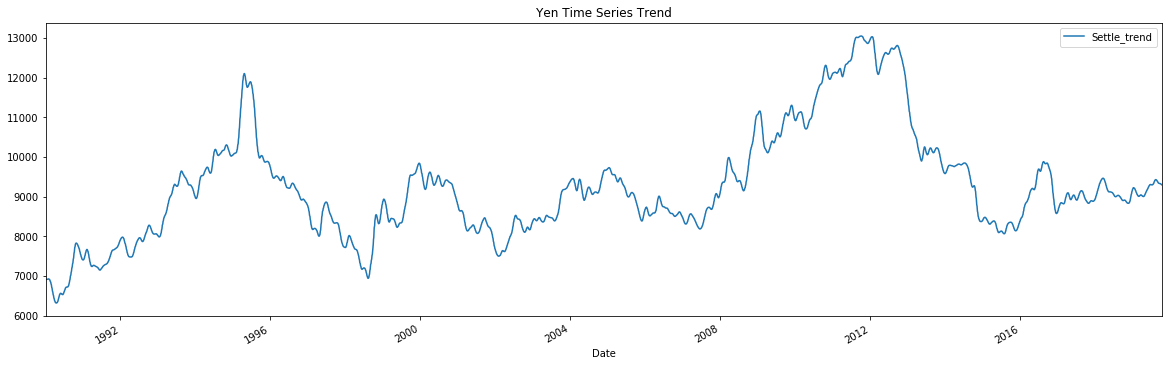

In [22]:
# Plot Yen TS trend
yen_ts_trend_plt = yen_ts_trend.plot(title="Yen Time Series Trend", figsize=(20,6), legend=True)

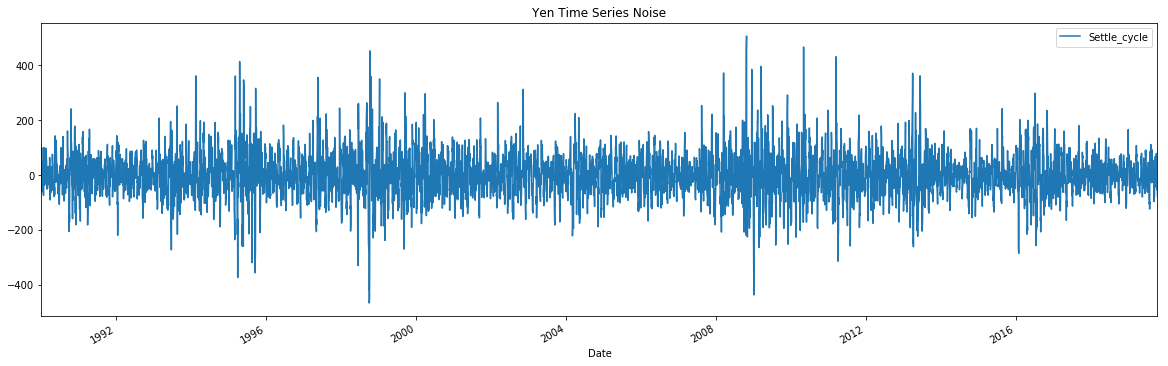

In [23]:
# Plot Yen TS noise
yen_ts_noise_plt = yen_ts_noise.plot(title="Yen Time Series Noise", figsize=(20,6), legend=True)

In [33]:
# Create a dataframe of just the settle price, and add columns for "noise" and "trend" series from above:
# Create dataframe with Settle
df = pd.DataFrame(yen_futures['Settle'])

# Add columns for Noise and Trend
df['Noise'] = yen_ts_noise
df['Trend'] = yen_ts_trend

df.head()

,Settle,Noise,Trend
Date,,,
1990-01-02,6847.0,-61.503967,6908.503967
1990-01-03,6887.0,-21.799756,6908.799756
1990-01-04,7008.0,98.942896,6909.057104
1990-01-05,6950.0,40.776052,6909.223948
1990-01-08,6959.0,49.689938,6909.310062


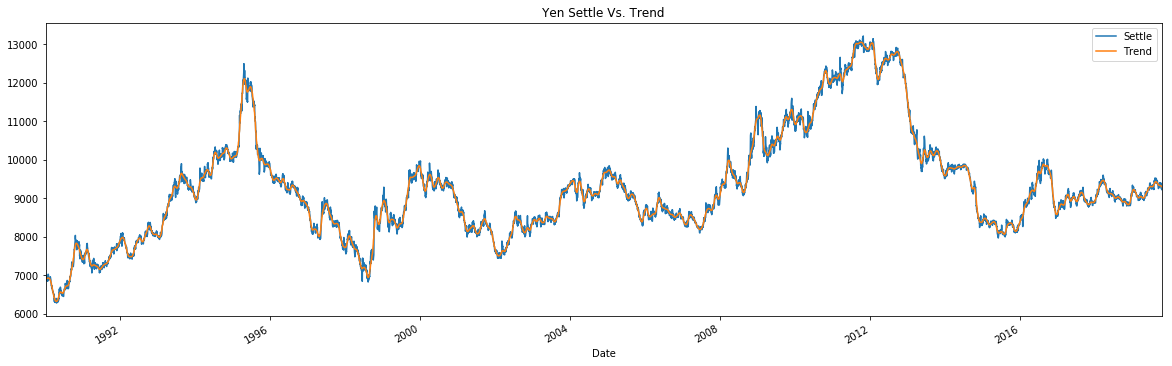

In [49]:
# Plot the Settle Price vs. the Trend
# YOUR CODE HERE!
settle_vs_trend_plt = (df['Settle'].plot(title="Yen Settle Vs. Trend", figsize=(20,6), legend=True), df['Trend'].plot(legend=True))

Smoothing with the HP Filter and plotting the resulting trend against the actual futures returns, we can see that there's a lot of short term fluctuations that deviate around this trend. Perhaps these would represent profitable trading opportunities: For example, when the blue line deviates far below the orange, we can see this as a sign that the Yen is temporarily more undervalued than it should be (and, therefore, we'd see this as a short-term buying opportunity).

In [ ]:
# Plot the Settle Noise
# YOUR CODE HERE!

---

# Forecasting Returns using an ARMA Model

Using futures Settle *Returns*, estimate an ARMA model

1. ARMA: Create an ARMA model and fit it to the returns data. Note: Set the AR and MA ("p" and "q") parameters to p=2 and q=1: order=(2, 1).
2. Output the ARMA summary table and take note of the p-values of the lags. Based on the p-values, is the model a good fit (p < 0.05)?
3. Plot the 5-day forecast of the forecasted returns (the results forecast from ARMA model)

In [ ]:
# Create a series using "Settle" price percentage returns, drop any nan"s, and check the results:
# (Make sure to multiply the pct_change() results by 100)
# In this case, you may have to replace inf, -inf values with np.nan"s
returns = (yen_futures[["Settle"]].pct_change() * 100)
returns = returns.replace(-np.inf, np.nan).dropna()
returns.tail()

In [ ]:
import statsmodels.api as sm

# Estimate and ARMA model using statsmodels (use order=(2, 1))
# YOUR CODE HERE!

# Fit the model and assign it to a variable called results
# YOUR CODE HERE!

In [ ]:
# Output model summary results:
# YOUR CODE HERE!

In [ ]:
# Plot the 5 Day Returns Forecast
# YOUR CODE HERE!

Question: Based on the p-value, is the model a good fit?

Answer:

---

# Forecasting the Settle Price using an ARIMA Model

 1. Using the *raw* Yen **Settle Price**, estimate an ARIMA model.
     1. Set P=5, D=1, and Q=1 in the model (e.g., ARIMA(df, order=(5,1,1))
     2. P= # of Auto-Regressive Lags, D= # of Differences (this is usually =1), Q= # of Moving Average Lags
 2. Output the ARIMA summary table and take note of the p-values of the lags. Based on the p-values, is the model a good fit (p < 0.05)?
 3. Construct a 5 day forecast for the Settle Price. What does the model forecast will happen to the Japanese Yen in the near term?

In [ ]:
from statsmodels.tsa.arima_model import ARIMA

# Estimate and ARIMA Model:
# Hint: ARIMA(df, order=(p, d, q))
# YOUR CODE HERE!

# Fit the model
# YOUR CODE HERE!

In [ ]:
# Output model summary results:
results.summary()

In [ ]:
# Plot the 5 Day Price Forecast
# YOUR CODE HERE!

What does the model forecast will happen to the Japanese Yen in the near term?

---

# Volatility Forecasting with GARCH

Rather than predicting returns, let's forecast near-term **volatility** of Japanese Yen futures returns. Being able to accurately predict volatility will be extremely useful if we want to trade in derivatives or quantify our maximum loss.
 
Using futures Settle *Returns*, estimate an GARCH model

1. GARCH: Create an GARCH model and fit it to the returns data. Note: Set the parameters to p=2 and q=1: order=(2, 1).
2. Output the GARCH summary table and take note of the p-values of the lags. Based on the p-values, is the model a good fit (p < 0.05)?
3. Plot the 5-day forecast of the volatility.

In [ ]:
import arch as arch

In [ ]:
# Estimate a GARCH model:
# YOUR CODE HERE!

# Fit the model
# YOUR CODE HERE!

In [ ]:
# Summarize the model results
# YOUR CODE HERE!

In [ ]:
# Find the last day of the dataset
last_day = returns.index.max().strftime('%Y-%m-%d')
last_day

In [ ]:
# Create a 5 day forecast of volatility
forecast_horizon = 5
# Start the forecast using the last_day calculated above
# YOUR CODE HERE!

In [ ]:
# Annualize the forecast
intermediate = np.sqrt(forecasts.variance.dropna() * 252)
intermediate.head()

In [ ]:
# Transpose the forecast so that it is easier to plot
final = intermediate.dropna().T
final.head()

In [ ]:
# Plot the final forecast
# YOUR CODE HERE!

---

# Conclusions

Based on your time series analysis, would you buy the yen now?

Is the risk of the yen expected to increase or decrease?

Based on the model evaluation, would you feel confident in using these models for trading?